In [3]:
# Semantic segmentation -> object masking
# Instance segmentation -> segmentation + classification
# Mask storing -> run-length encoding RLE

# Convolution ->> classification --> Deconvolution             

In [18]:
!pip install scipy

  Obtaining dependency information for scipy from https://files.pythonhosted.org/packages/ef/1b/7538792254aec6850657d5b940fd05fe60582af829ffe40d6c054f065f34/scipy-1.11.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 505.6 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 5.3 MB/s eta 0:00:0000:0100:01


In [19]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, UpSampling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

/tmp/ipykernel_11308/2570875815.py:6: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  img = Image.fromarray(misc.face())


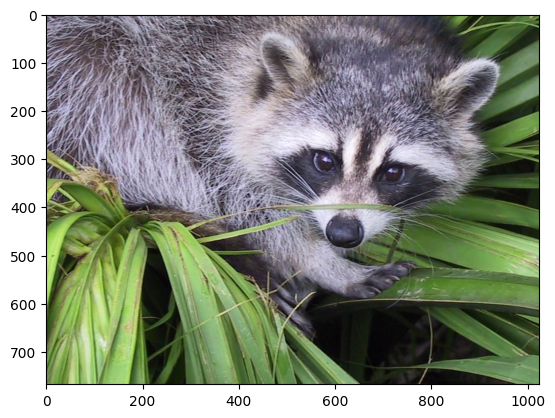

In [22]:
from scipy import misc
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

img = Image.fromarray(misc.face())
plt.imshow(img)


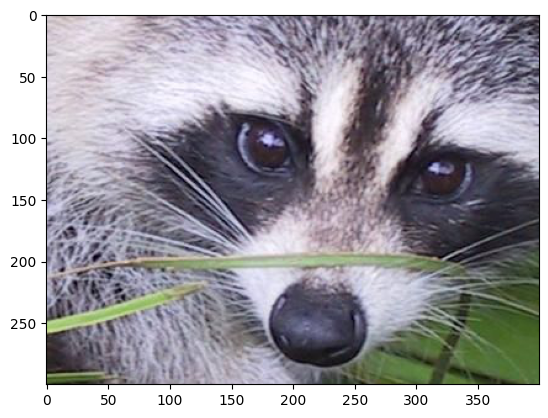

In [41]:
#--------------------x1---y1  x2  y2
crop_img = img.crop((400,200,800,500))
plt.imshow(crop_img)

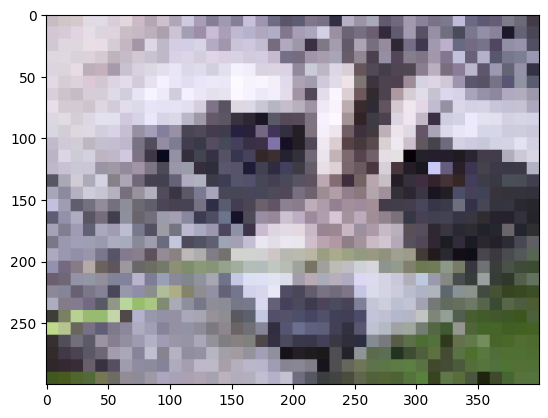

In [48]:
resized_img = crop_img.resize((40,30),resample=Image.NEAREST)
resized_img = resized_img.resize((400,300),resample=Image.NEAREST)
plt.imshow(resized_img)

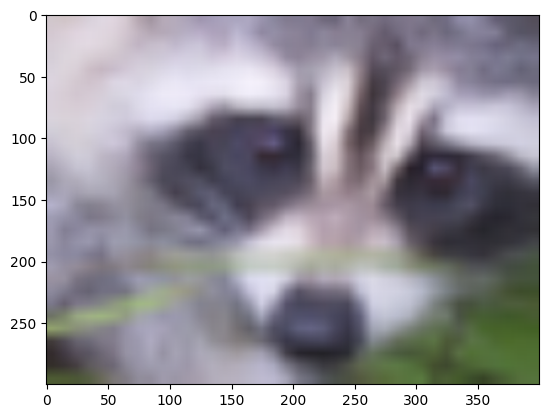

In [49]:
resized_img = crop_img.resize((40,30),resample=Image.BILINEAR)
resized_img = resized_img.resize((400,300),resample=Image.BILINEAR)
plt.imshow(resized_img)

In [132]:
# value of strides multiplicate the image size
model = Sequential([Conv2DTranspose(filters=3, kernel_size=(11,11), strides=(1,1), padding='same', input_shape=(224,224,3))])
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose_25 (Conv2  (None, 224, 224, 3)       1092      
 DTranspose)                                                     
                                                                 
Total params: 1092 (4.27 KB)
Trainable params: 1092 (4.27 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


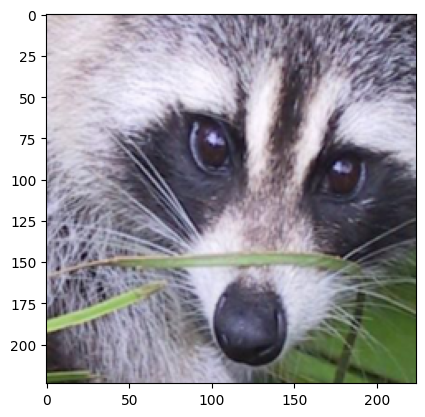

In [133]:
resized_img = crop_img.resize((224,224),resample=Image.BILINEAR)
resized_img = np.array(resized_img)/255.0
plt.imshow(resized_img)

1/1 [==============================] - 0s 185ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


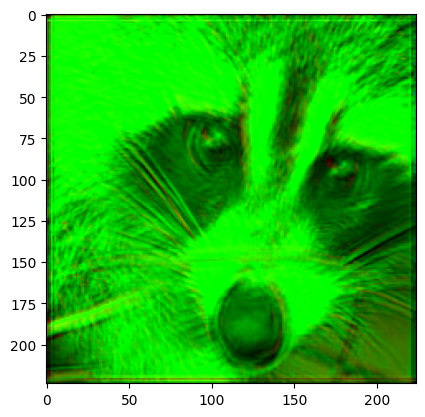

In [134]:
predicted = model.predict(resized_img[None])[0]
plt.imshow(predicted)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 up_sampling2d_2 (UpSamplin  (None, 448, 448, 3)       0         
 g2D)                                                            
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
1/1 [==============================] - 0s 28ms/step


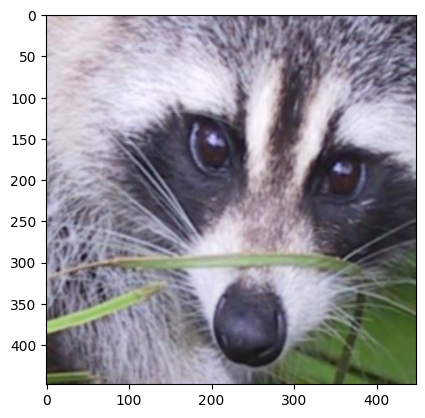

In [65]:
model = Sequential([
    UpSampling2D(size=(2,2),interpolation='bilinear',input_shape=(224,224,3))
])
model.summary()
predicted = model.predict(resized_img[None])[0]
plt.imshow(predicted)

In [90]:
def auto_encoder(input_size=(28,28,1)):
    input = Input(input_size)
    x = Conv2D(32,(3,3),padding="same",activation="relu")(input)
    x = BatchNormalization()(x)
    x = Conv2D(32,(3,3),padding="same",activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    #--- 14х14
    x = Conv2D(64,(3,3),padding="same",activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(128,(3,3),padding="same",activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)
    #--- 7х7
    x = Conv2DTranspose(128,(2,2),strides=(2,2),padding='same',activation='relu')(x)
    x = BatchNormalization()(x)
    #--- 14x14
    x = Conv2DTranspose(64,(2,2),strides=(2,2),padding="same",activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(32,(3,3),padding="same",activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(32,(3,3),padding="same",activation="relu")(x)
    x = BatchNormalization()(x)
    #--- 28x28
    x = Conv2D(1,(3,3),activation='sigmoid',padding='same')(x)
    model=Model(input,x)
    model.compile(optimizer=Adam(),loss='mean_squared_error')
    return model





In [98]:
from tensorflow.keras.datasets import mnist

(x_train,y_train),(x_test,y_test) = mnist.load_data()
print (x_train.shape)

x_train = x_train / 255
x_test = x_test/255

x_train = x_train.reshape(x_train.shape[0],28,28,1)
x_test = x_test.reshape(x_test.shape[0],28,28,1)
print (x_train.shape)

y_train_pix = x_train.copy();
y_test_pix = x_test.copy();

noise = 0.01
x_train += np.random.randn(x_train.shape[0],28,28,1)*noise
x_test += np.random.randn(x_test.shape[0],28,28,1)*noise




(60000, 28, 28)
(60000, 28, 28, 1)


In [93]:
model = auto_encoder()
model.summary()
hist = model.fit(x_train[:10000],y_train_pix[:10000],epochs=10,batch_size=200,validation_data=(x_test,y_test_pix))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_35 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_36 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 32)        0   

In [93]:
model = auto_encoder()
model.summary()
hist = model.fit(x_train[:10000],y_train_pix[:10000],epochs=10,batch_size=200,validation_data=(x_test,y_test_pix))

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_30 (Conv2D)          (None, 28, 28, 32)        320       
                                                                 
 batch_normalization_35 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 conv2d_31 (Conv2D)          (None, 28, 28, 32)        9248      
                                                                 
 batch_normalization_36 (Ba  (None, 28, 28, 32)        128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 14, 14, 32)        0   

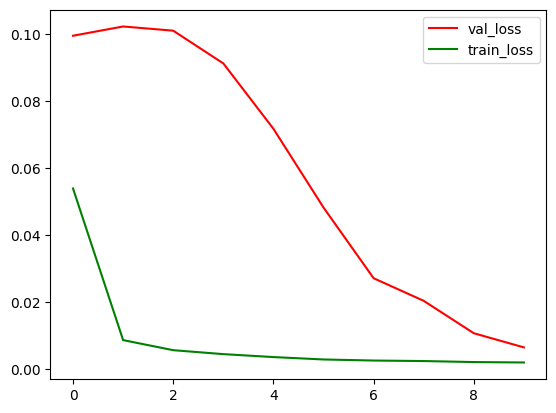

In [94]:
plt.plot(hist.history['val_loss'],'r',label='val_loss')
plt.plot(hist.history['loss'],'g',label='train_loss')
plt.legend()
plt.show()

In [95]:
y_pred = model.predict(x_test)

313/313 [==============================] - 13s 42ms/step


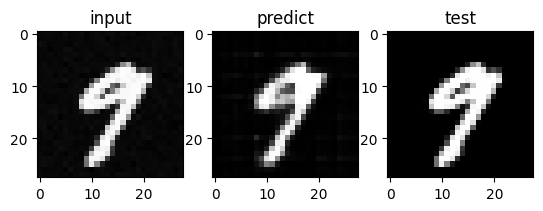

Dice Similarity: 0.7532467532467533
Dice Similarity: 0.8571428571428571
Dice Similarity: 0.7272727272727273
Dice Similarity: 0.8977777777777778
Dice Similarity: 0.647887323943662
Dice Similarity: 0.8656716417910447
Dice Similarity: 0.6923076923076923
Dice Similarity: 0.84
Dice Similarity: 0.8571428571428571
Dice Similarity: 0.8311688311688312
Dice Similarity: 0.8524590163934426
Dice Similarity: 0.5681818181818182
Dice Similarity: 0.7628865979381443
Dice Similarity: 0.7943262411347518
Dice Similarity: 0.8817204301075269
Dice Similarity: 0.5373134328358209
Dice Similarity: 0.7326732673267327
Dice Similarity: 0.8214285714285714
Dice Similarity: 0.8045977011494253
Dice Similarity: 0.6779661016949152
Dice Similarity: 0.8
Dice Similarity: 0.7835051546391752
Dice Similarity: 0.7083333333333334
Dice Similarity: 0.5428571428571428
Dice Similarity: 0.25
Dice Similarity: 0.9240121580547113
Dice Similarity: 0.6122448979591837
Dice Similarity: 0.803921568627451
Dice Similarity: 0.8494623655913979
D

In [152]:
number =20
fig,ax = plt.subplots(1,3)
ax[0].imshow(x_test[number, ...,0], cmap='gray')
ax[0].set_title('input')
ax[1].imshow(y_pred[number, ...,0], cmap='gray')
ax[1].set_title('predict')
ax[2].imshow(y_test_pix[number, ...,0], cmap='gray')
ax[2].set_title('test')
plt.show()


def threshold_dice(pred, test, threshold = 0.85):
    value_intersection = pred[test>=threshold];
    intersection = np.sum(value_intersection>=threshold) * 2.0
    dice = intersection / (np.sum(pred>=threshold) + np.sum(test>=threshold))
    return dice

#threshold_dice(y_test_pix[number],y_test_pix[number],threshold=0.0)

for (pred,test) in zip(y_pred,y_test_pix):
    print ("Dice Similarity: {}".format(threshold_dice(pred,test)))


In [ ]:
#
# SegNet, Unet, FeaturePyramidNetwork
#
# Dice Metric, IoU -> is the quality of masking

In [ ]:
from tensorflow.keras.layers import (Activation, Input, MaxPooling2D,
BatchNormalization, Conv2D, Conv2DTransponse,concatenate)
from tensorlow.keras.utils import plot_model

def unet(num_classes=14,input_shape=(200,600,3)):
    input = Input(input_size)
    
    x = Conv2D(64,(3,3),padding="same",name="b1c1")(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(64,(3,3),padding="same",name="b1c2")(x)
    x = BatchNormalization()(x)
    x_b1c2 = Activation('relu')(x)
    x = MaxPooling2D()(x_b1c2)

    x = Conv2D(128,(3,3),padding="same",name="b2c1")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128,(3,3),padding="same",name="b2c2")(x)
    x = BatchNormalization()(x)
    x_b2c2 = Activation('relu')(x)
    x = MaxPooling2D()(x_b2c2)

    x = Conv2D(256,(3,3),padding="same",name="b3c1")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(256,(3,3),padding="same",name="b3c2")(x)
    x = BatchNormalization()(x)
    x_b3c2 = Activation('relu')(x)
    x = MaxPooling2D()(x_b3c2)




    
    x = Conv2D(128,(3,3),padding="same",name="b2c1")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(128,(3,3),padding="same",activation="relu")(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D()(x)




    
    #--- 7х7
    x = Conv2DTranspose(128,(2,2),strides=(2,2),padding='same',activation='relu')(x)
    x = BatchNormalization()(x)
    #--- 14x14
    x = Conv2DTranspose(64,(2,2),strides=(2,2),padding="same",activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(32,(3,3),padding="same",activation="relu")(x)
    x = BatchNormalization()(x)
    x = Conv2D(32,(3,3),padding="same",activation="relu")(x)
    x = BatchNormalization()(x)
    #--- 28x28
    x = Conv2D(1,(3,3),activation='sigmoid',padding='same')(x)
    model=Model(input,x)
    model.compile(optimizer=Adam(),loss='mean_squared_error')
    return model